In this notebook we will try to predict wine quality based on various chemical properties. 


# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import GridSearchCV
import IPython
from sklearn.model_selection import KFold
import warnings

warnings.filterwarnings('ignore')

np.random.seed(42) 
np.random.RandomState(42)
random.seed(42)
cv = KFold(n_splits=5, random_state=42)

#Trying out regression

## Preparing the data

Let's start with downloading the data.

In [2]:
red = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep=';' )
white = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", sep=';' )

In [3]:
red.tail(), white.tail()

(      fixed acidity  volatile acidity  citric acid  ...  sulphates  alcohol  quality
 1594            6.2             0.600         0.08  ...       0.58     10.5        5
 1595            5.9             0.550         0.10  ...       0.76     11.2        6
 1596            6.3             0.510         0.13  ...       0.75     11.0        6
 1597            5.9             0.645         0.12  ...       0.71     10.2        5
 1598            6.0             0.310         0.47  ...       0.66     11.0        6
 
 [5 rows x 12 columns],
       fixed acidity  volatile acidity  citric acid  ...  sulphates  alcohol  quality
 4893            6.2              0.21         0.29  ...       0.50     11.2        6
 4894            6.6              0.32         0.36  ...       0.46      9.6        5
 4895            6.5              0.24         0.19  ...       0.46      9.4        6
 4896            5.5              0.29         0.30  ...       0.38     12.8        7
 4897            6.0        

Now we will create a new dummy variable 'red' indicating whether the wine is red or not, and combine both sets.

In [4]:
df_red = red
df_white = white
red.insert(0, 'red', 1)
white.insert(0, 'red', 0)
df= pd.concat([red, white])

df.sample(10)

,red,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1504,0,7.0,0.17,0.74,12.8,0.045,24.0,126.0,0.99420,3.26,0.38,12.2,8
1419,1,7.7,0.64,0.21,2.2,0.077,32.0,133.0,0.99560,3.27,0.45,9.9,5
3162,0,6.8,0.39,0.34,7.4,0.020,38.0,133.0,0.99212,3.18,0.44,12.0,7
3091,0,6.3,0.28,0.47,11.2,0.040,61.0,183.0,0.99592,3.12,0.51,9.5,6
2433,0,7.4,0.35,0.20,13.9,0.054,63.0,229.0,0.99888,3.11,0.50,8.9,6
1297,1,7.2,0.53,0.14,2.1,0.064,15.0,29.0,0.99323,3.35,0.61,12.1,6
174,0,7.5,0.27,0.31,17.7,0.051,33.0,173.0,0.99900,3.09,0.64,10.2,5
3985,0,6.8,0.11,0.27,8.6,0.044,45.0,104.0,0.99454,3.20,0.37,9.9,6
561,1,9.0,0.44,0.49,2.4,0.078,26.0,121.0,0.99780,3.23,0.58,9.2,5
4347,0,7.1,0.23,0.30,2.6,0.034,62.0,148.0,0.99121,3.03,0.56,11.3,7



We are not creating separate variable indicator 'white' as it carries no new information and creates a severe multicollinearity problem for the analysis (Dummy Variable Trap).

Let's chceck if atributes are of correct types.

In [5]:
df.dtypes

red                       int64
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

Now we need to handle the missing values.


In [6]:
df.isna().any()

red                     False
fixed acidity           False
volatile acidity        False
citric acid             False
residual sugar          False
chlorides               False
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
dtype: bool

There are no missing values. We can check if there are any duplicates.

In [7]:
print('There are {0:.2f}% duplicates'.format(df.duplicated().sum() / len(df.index)*100))

There are 18.12% duplicates


We wil drop the dupplicates before futher preparations.

In [8]:
df.drop_duplicates(inplace=True)

We might want to look into some basic informations about our data. This way we can for instance locate attributes with 0 variance or look for outliers.

In [9]:
df.describe()

,red,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000
mean,0.255451,7.215179,0.344130,0.318494,5.048477,0.056690,30.036654,114.109023,0.994535,3.224664,0.533357,10.549241,5.795677
std,0.436155,1.319671,0.168248,0.147157,4.500180,0.036863,17.805045,56.774223,0.002966,0.160379,0.149743,1.185933,0.879772
min,0.000000,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,0.000000,6.400000,0.230000,0.240000,1.800000,0.038000,16.000000,74.000000,0.992200,3.110000,0.430000,9.500000,5.000000
50%,0.000000,7.000000,0.300000,0.310000,2.700000,0.047000,28.000000,116.000000,0.994650,3.210000,0.510000,10.400000,6.000000
75%,1.000000,7.700000,0.410000,0.400000,7.500000,0.066000,41.000000,153.250000,0.996770,3.330000,0.600000,11.400000,6.000000
max,1.000000,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


Looking at the differences between 75% percentile and max values, we see that in fact there might be some outliers. Next we will make a pairplot.

In [10]:
# sns.pairplot(df)

![test](https://docs.google.com/uc?export=download&id=1I4WEqnalJYBaMpH7iRsmhxMBbtuz9f6I)


There are no obvius patterns, but we see that in fact there are some outliers.To take care of them we will use z-score.

In [11]:
from scipy import stats

df = df[(np.abs(stats.zscore(df)) < 4).all(axis=1)]
# sns.pairplot(df)

![test](https://docs.google.com/uc?export=download&id=1V7Pb5PbP59a-yTBOt4-4BY3DuPrerHt4)

In [12]:
df.describe()

,red,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,5165.000000,5165.000000,5165.000000,5165.000000,5165.000000,5165.000000,5165.000000,5165.000000,5165.000000,5165.000000,5165.000000,5165.000000,5165.000000
mean,0.241626,7.158887,0.338252,0.314867,5.052546,0.053811,30.050823,114.812875,0.994440,3.225895,0.526498,10.558425,5.809487
std,0.428110,1.207850,0.160008,0.140421,4.398352,0.025109,16.857506,55.690506,0.002853,0.157989,0.134019,1.186330,0.872434
min,0.000000,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,0.000000,6.400000,0.230000,0.240000,1.800000,0.038000,17.000000,77.000000,0.992140,3.120000,0.430000,9.500000,5.000000
50%,0.000000,6.900000,0.290000,0.310000,2.800000,0.047000,28.000000,117.000000,0.994580,3.220000,0.510000,10.400000,6.000000
75%,0.000000,7.700000,0.400000,0.390000,7.500000,0.064000,41.000000,154.000000,0.996660,3.330000,0.600000,11.400000,6.000000
max,1.000000,12.400000,1.010000,0.880000,22.600000,0.204000,101.000000,303.000000,1.002890,3.850000,1.130000,14.200000,9.000000


We have dropped 155 instances, but we see that there are no outliers now.

Let's take a look at correlation matrix.

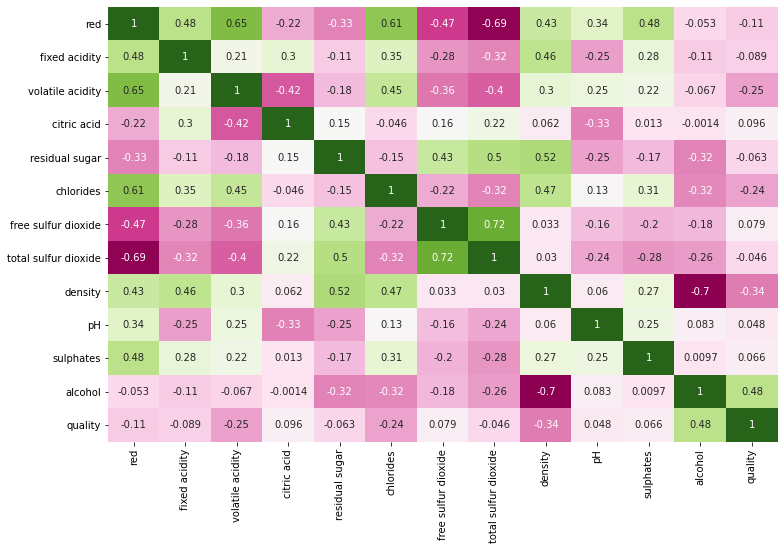

In [13]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap='PiYG', cbar=False)

We see that quality is correlated mostly with


*   alcohol (0.48),
*   density  (-0.34),
*   volatile acidity (-0.25),
*   chlorides (-0.24).

Looks like we should consider buying harder wines if we want the top notch quality.
What's interesting, quality is negatively correlated with attribute 'red' which means that white wines are usually better than red ones.

We may expect our data to be imbalanced as good wines are rare.

The histogram shows the balance of 'quality' attribute

(array([  20.,  193., 1691., 2264.,  846.,  146.,    5.]),
 array([2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <a list of 7 Patch objects>)

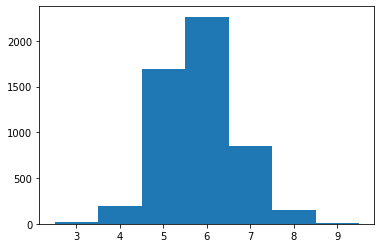

In [14]:
plt.hist(df.quality,
         bins=np.linspace(df.quality.min()-0.5, df.quality.max()+0.5, len(np.unique(df.quality))+1) )

The data is extremly unabalnced with only 5 wines of quality 9 and 30 of quality 3.
For regression that's a problem we need to deal with. We will use SMOTE oversampling method, but for that purpose we need to drop quality 9 and 3 wines.

(array([ 193., 1691., 2264.,  846.,  146.]),
 array([3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 <a list of 5 Patch objects>)

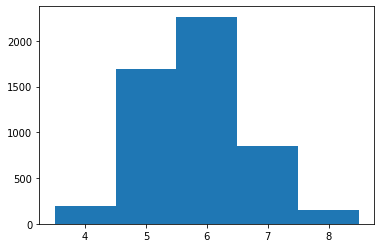

In [15]:
df = df[df.quality!=3]
df = df[df.quality!=9]

plt.hist(df.quality,
         bins=np.linspace(df.quality.min()-0.5, df.quality.max()+0.5, len(np.unique(df.quality))+1) )

Before oversampling we need to split the data into train and test subsets, also let's normalize the features.

In [16]:
from sklearn.model_selection import train_test_split

X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

min = X_train.min()
max = X_train.max()
for name in df.columns[:-1]:
  X_train[name] = (X_train[name] - min[name]) / (max[name] - min[name])
  X_test[name] = (X_test[name] - min[name]) / (max[name] -min[name])


In [17]:
X_test.describe()

,red,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000
mean,0.254864,0.403346,0.284308,0.361470,0.193040,0.233224,0.284621,0.358345,0.469953,0.452274,0.346710,0.417608
std,0.436209,0.149216,0.174573,0.151295,0.198949,0.125272,0.164106,0.190379,0.188529,0.141271,0.149802,0.189239
min,0.000000,0.104651,0.021505,0.000000,0.004545,0.041026,0.020000,-0.003378,0.006971,0.070796,0.032967,0.096774
25%,0.000000,0.302326,0.161290,0.295455,0.050000,0.148718,0.160000,0.219595,0.315272,0.353982,0.241758,0.258065
50%,0.000000,0.372093,0.236559,0.363636,0.086364,0.200000,0.260000,0.371622,0.478137,0.442478,0.318681,0.387097
75%,1.000000,0.476744,0.358871,0.454545,0.280682,0.297436,0.390000,0.489865,0.618663,0.548673,0.439560,0.548387
max,1.000000,0.976744,0.994624,0.840909,0.872727,0.876923,0.840000,0.854730,0.932193,0.849558,0.978022,0.967742


In [18]:
X_train.describe()

,red,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,4626.000000,4626.000000,4626.000000,4626.000000,4626.000000,4626.000000,4626.000000,4626.000000,4626.000000,4626.000000,4626.000000,4626.000000
mean,0.240164,0.388700,0.276603,0.357240,0.203462,0.229369,0.291565,0.365221,0.463779,0.447061,0.335942,0.412133
std,0.427229,0.138747,0.171336,0.160434,0.200005,0.128628,0.168989,0.187816,0.179689,0.139622,0.147021,0.191351
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.302326,0.161290,0.272727,0.054545,0.148718,0.160000,0.239865,0.319392,0.353982,0.230769,0.241935
50%,0.000000,0.360465,0.225806,0.352273,0.100000,0.194872,0.270000,0.371622,0.472117,0.442478,0.318681,0.387097
75%,0.000000,0.441860,0.344086,0.443182,0.318182,0.282051,0.400000,0.496622,0.601394,0.539823,0.417582,0.548387
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now up with the balancing.

(array([2264., 2264., 2264., 2264., 2264.]),
 array([3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 <a list of 5 Patch objects>)

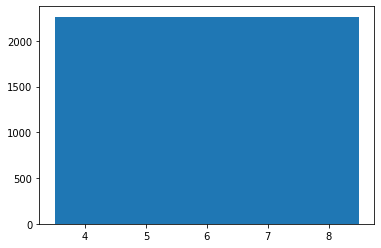

In [19]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_oversampled, y_oversampled = sm.fit_resample(X, y)
X_train = pd.DataFrame(X_train, columns=X_train.columns)
X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
X_train_oversampled = pd.DataFrame(X_train_oversampled, columns=X_train.columns)

plt.hist(y_oversampled,
         bins=np.linspace( y_oversampled.min()-0.5, y_oversampled.max()+0.5, len(np.unique(y_oversampled))+1 )  )



## Model selection

Too choose right model we will use cross validation. Splitting oversampled data into folds is a bad idea because there is high probability that instances from validation set will be in training set as well. A better idea would be to first split into folds and then in each fold oversample the training data. Let's create a function that scores models with oversampling. We will base our choice on four particular metrics: R2, MSE, MAE and lastly a custom one: MQE. MQE - mean qualiy error - will calculate MAE  but with our predictions rounded to integers.

In [20]:
from sklearn.model_selection import KFold
from sklearn import metrics

def val_scores(model, X=X_train, y=y_train, folds=5):
  cv = KFold(n_splits=folds, random_state=42)
  
  R2 = []
  MSE = []
  MAE = []
  MQE = []
  for train_fold_index, val_fold_index in cv.split(X, y):
    X_train_fold, y_train_fold = sm.fit_resample(X.iloc[train_fold_index],
                                                 y.iloc[train_fold_index])  #sm was created earlier
    X_val_fold, y_val_fold = X.iloc[val_fold_index], y.iloc[val_fold_index]

    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_val_fold)

    R2.append(metrics.r2_score(y_val_fold, y_pred))
    MSE.append(metrics.mean_squared_error(y_val_fold, y_pred))
    MAE.append(metrics.mean_absolute_error(y_val_fold, y_pred))
    MQE.append(metrics.mean_absolute_error(y_val_fold, np.round(y_pred)))

  return {'R2':np.mean(R2), 'MSE':np.mean(MSE), 'MAE':np.mean(MAE), 'MQE':np.mean(MQE)}

Now let's try a bunch od algorithms and choose the best one.

In [21]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor


models=[linear_model.LinearRegression(),
        linear_model.Lasso(),
        linear_model.TheilSenRegressor(random_state=42),
        linear_model.HuberRegressor(),
        linear_model.BayesianRidge(),
        linear_model.PassiveAggressiveRegressor(random_state=42),
        linear_model.LogisticRegression(),
        DecisionTreeRegressor(random_state=42),
        KNeighborsRegressor(),
        GradientBoostingRegressor(random_state=42),
        RandomForestRegressor(random_state=42)]

In [22]:
for model in models: 
  print(type(model).__name__)
  print(val_scores(model))

LinearRegression
{'R2': 0.04743871587716022, 'MSE': 0.6903792927708042, 'MAE': 0.6571094038330141, 'MQE': 0.6180269686533185}
Lasso
{'R2': -0.04373594802569665, 'MSE': 0.7583218726285681, 'MAE': 0.6247296713560212, 'MQE': 0.6247296713560212}
TheilSenRegressor
{'R2': -0.08200947433950405, 'MSE': 0.78400948998649, 'MAE': 0.7042254946517804, 'MQE': 0.6642900005837371}
HuberRegressor
{'R2': 0.0008953800991649219, 'MSE': 0.7241534030816889, 'MAE': 0.6715915526242636, 'MQE': 0.63229373650108}
BayesianRidge
{'R2': 0.04926704478123536, 'MSE': 0.6890653761677827, 'MAE': 0.6564867512155297, 'MQE': 0.6182429513747009}
PassiveAggressiveRegressor
{'R2': -0.833465143558626, 'MSE': 1.3184622648277724, 'MAE': 0.923400418528491, 'MQE': 0.8977820325725293}
LogisticRegression
{'R2': -0.7922747394272187, 'MSE': 1.29678430914716, 'MAE': 0.8216545443932052, 'MQE': 0.8216545443932052}
DecisionTreeRegressor
{'R2': -0.4576867389184344, 'MSE': 1.0570652034323742, 'MAE': 0.7263263090304127, 'MQE': 0.726326309030

Random forest regressor did by far the best. Linear regression scored  high for such a basic algorithm, so it may be worth checking higher degree pomynomial regressions.

In [23]:
from sklearn.preprocessing import PolynomialFeatures

degrees = [1,2,3]
model = linear_model.LinearRegression()
for deg in degrees:
  poly = PolynomialFeatures(degree=deg)
  X_poly = pd.DataFrame(poly.fit_transform(X_train))
  print('degreee {}:'.format(deg))
  print( val_scores(model, X=X_poly))  

degreee 1:
{'R2': 0.04743871587715962, 'MSE': 0.6903792927708048, 'MAE': 0.6571094038330143, 'MQE': 0.6180269686533185}
degreee 2:
{'R2': 0.02826264577887543, 'MSE': 0.703552680970882, 'MAE': 0.6567287184587639, 'MQE': 0.6162993403770942}
degreee 3:
{'R2': -0.5226996693243997, 'MSE': 1.0985033218830413, 'MAE': 0.7364600977628761, 'MQE': 0.6882834627283871}


Increasing the degree won't save linear regression. 

Random forest regressor scored highest among tested models. Let's try combining it with our second place holder - gradient boosting regressor.

In [24]:
from sklearn.ensemble import VotingRegressor

RFR = RandomForestRegressor(random_state=42)
GBR = GradientBoostingRegressor(random_state=42)
model = VotingRegressor(estimators=[('RFR', RFR),('GBR',GBR)])
val_scores(model)

{'MAE': 0.5644450796359667,
 'MQE': 0.5151342011557994,
 'MSE': 0.528263076882932,
 'R2': 0.2710490258977668}

Cobining both regressors didn't work out so well, we got an estimator which is worse than it's single component - RFR. Let's stick with RFR and try to improve it a bit.

## Hyper parameter optimization.

We will perform Ranomized grid search, as there are many paramters we can tune.




In [25]:
RFR = RandomForestRegressor(random_state=42)

n_estimators = [100, 200, 300]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [x for x in range(1,10)]
max_depth.append(None)
min_samples_split = [2, 3, 5, 8, 10]
min_samples_leaf = [1, 2, 3, 4, 5]
bootstrap = [True, False]

random_grid = {'regression__n_estimators': n_estimators,
               'regression__max_features': max_features,
               'regression__max_depth': max_depth,
               'regression__min_samples_split': min_samples_split,
               'regression__min_samples_leaf': min_samples_leaf,
               'regression__bootstrap': bootstrap,
                }


To use grid search with oversampling we will use imblearn pipelines.

In [26]:
from imblearn.pipeline import Pipeline

RFR = RandomForestRegressor(random_state=42)
oversampled_RFR=Pipeline([ ('sampling', sm), ('regression',RFR) ])

Let's create MQE scoring system.

In [27]:
from sklearn.metrics import  make_scorer

def MQE_loss(y_true, y_pred):
  return metrics.mean_absolute_error(y_true, np.round(y_pred))

MQE_scorer = make_scorer(MQE_loss, greater_is_better=False)

Now up witth the grid search.

In [28]:
from sklearn.model_selection import RandomizedSearchCV

RFR_random = RandomizedSearchCV(estimator = oversampled_RFR,
                                param_distributions = random_grid,
                                n_iter = 50,
                                cv = 3,
                                verbose=2,
                                random_state=42,
                                n_jobs = -1,
                                scoring = MQE_scorer
                                )
# RFR_random.fit(X_train, y_train)
# print(RFR_random.best_params_)
# print(RFR_random.best_score_)
# best_RFR = RFR_random.best_estimator_

# results:
best_params = {'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 300,
 'random_state': 42}
best_RFR = RandomForestRegressor(**best_params)

Let's use the val_score function to look at the scores of our best estimator. 

In [29]:
print('base RFR:', val_scores(RFR))
print('optimized RFR:', val_scores(best_RFR))

base RFR: {'R2': 0.2938043541904272, 'MSE': 0.5119094924522795, 'MAE': 0.5526331445916759, 'MQE': 0.497192925106532}
optimized RFR: {'R2': 0.36784404860764075, 'MSE': 0.45867345199877174, 'MAE': 0.5243485093294467, 'MQE': 0.472765396065612}


R2 score jumped from 0.29 to 0.37, this is roughly a 30% increase. The improvement in other scores is not that significant but it is better than it was before.

##Results

Let's start by plotting a histogram that ilustrates the ditribution of differences between our predictions and true values.

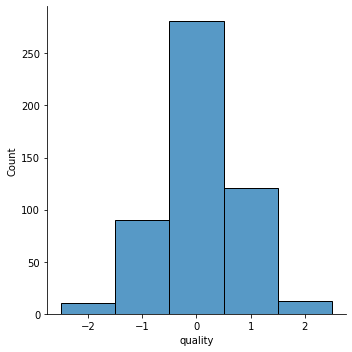

In [30]:
best_RFR.fit(X_train_oversampled, y_train_oversampled)
y_pred = np.round(best_RFR.predict(X_test))
plot = sns.displot(y_pred - y_test, discrete=True)


In vast majority of our predictions we are eiter correct or wrong by one quality class. That's quite good, but we shouldn't be too optimistic yet. As we remember our data set is imbalanced and so is the testing set. That means we could get a simmilar errors distribution by predicting every wine to be of avarege quality. We have to dive deeper into tests. We will make a confusion matrix, and see if our concerns are true.

Text(51.0, 0.5, 'True quality')

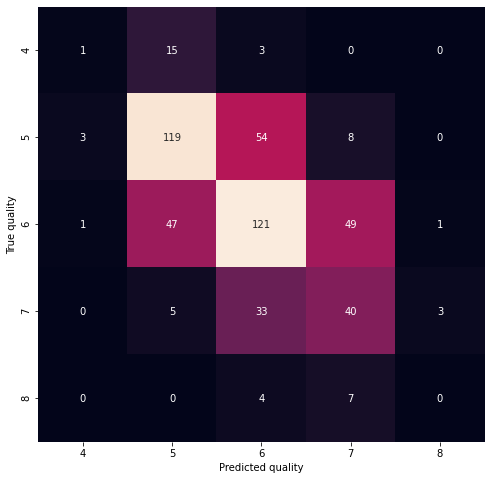

In [31]:
from sklearn.metrics import confusion_matrix


plt.figure(figsize=(8,8))
labels = sorted(y_test.unique())
con = confusion_matrix(y_test, y_pred, labels=labels)

sns.heatmap(con,
            annot=True,
            fmt ='d',
            xticklabels=labels,
            yticklabels=labels,
            cbar=False)
plt.xlabel('Predicted quality')
plt.ylabel('True quality')


It turns out our predictor is not as good as we tought... Out of 11  wines of quality 8 we did not guessed corectly even one... Looking on the bright side it could be worse. As we see our predictions tend to concentrate around diagonal which is a good sign, our predictor is beetter than nothing. Nonetheless we may feel disapointed by the results.

Let's take a look on what were the main factors for our model when making predictions.

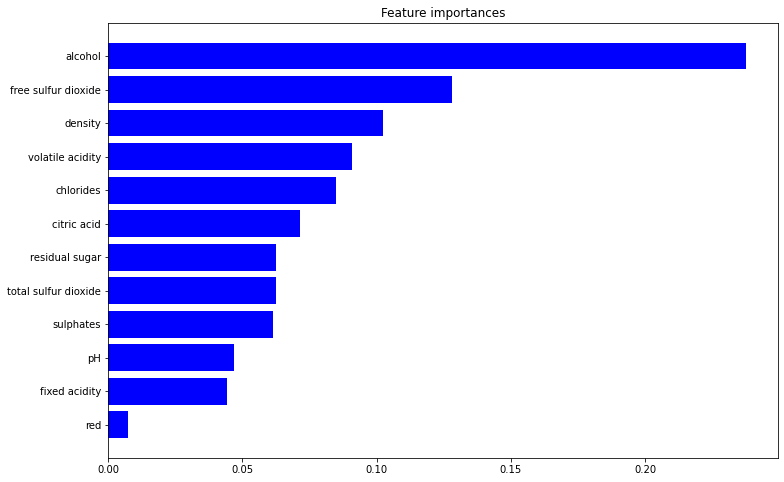

In [32]:
plt.figure(figsize=(12,8))
importances = best_RFR.feature_importances_
indices = np.argsort(importances)
feature = X_train_oversampled.columns
plt.title('Feature importances')
plt.barh(range(len(indices)), importances[indices], color='blue', align='center')
plt.yticks(range(len(indices)), feature[indices])
plt.show()

To remind, that were the attributes highest correlated with quality variable:
*   alcohol (0.48),
*   density  (-0.34),
*   volatile acidity (-0.25),
*   chlorides (-0.24).

Suprisingly free sulfur dioxide had almost zero correlation with the quality (0.08) but ended up being second most important factor for predictions. Color of the wine has almost zero importance.

 Lastly let's take a look on shap valuess of our model.

In [33]:
# !pip install shap
# import shap

# shap_values = shap.TreeExplainer(best_RFR).shap_values(X_train)
# shap.summary_plot(shap_values, X_train, plot_type='dot',  plot_size=(12,8))
# plt.savefig('RFR_shap')


![test](https://docs.google.com/uc?export=download&id=1PK3MJgY3Zlmr8Z0TLFbDIS1pallB7ts2)

Just as we expected based on covariance matrix, the concentration of alcohol has high impact on model predictions.

#Lowering the expectations - binary classification

Predicting wine quality appears to be harder than we tought. We will try classificating wines to be either good (quality 7 or higher) or not that good (quality 6 or lower). Lets start form base data set, as the transformations we will perform this time may differ from what we did previous. For example this time there is no reason to drop quality 9 and quality 3 wines.

## Data preparation

We will perform the same operations as in regression, but we will also axchange quality variable with 'good'.

In [34]:
red = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep=';' )
white = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", sep=';' )

red.insert(0, 'red', 1)
white.insert(0, 'red', 0)

df= pd.concat([red, white])

df['good'] = np.where(df.quality>=7, 1, 0)
df.drop('quality', axis=1, inplace=True)

df.drop_duplicates(inplace=True)

df.sample(10)

,red,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,good
1443,0,7.0,0.180,0.49,5.30,0.040,34.0,125.0,0.99140,3.24,0.40,12.200000,0
4010,0,7.2,0.210,0.29,3.10,0.044,39.0,122.0,0.99143,3.00,0.60,11.300000,0
527,0,6.1,0.280,0.22,1.80,0.034,32.0,116.0,0.98980,3.36,0.44,12.600000,0
581,0,5.7,0.180,0.22,4.20,0.042,25.0,111.0,0.99400,3.35,0.39,9.400000,0
4569,0,6.2,0.200,0.32,2.80,0.050,17.0,126.0,0.99360,3.18,0.55,9.400000,0
1390,1,6.0,0.490,0.00,2.30,0.068,15.0,33.0,0.99292,3.58,0.59,12.500000,0
4827,0,6.7,0.220,0.33,1.20,0.036,36.0,86.0,0.99058,3.10,0.76,11.400000,0
4507,0,5.1,0.305,0.13,1.75,0.036,17.0,73.0,0.99000,3.40,0.51,12.333333,0
3206,0,6.6,0.290,0.39,6.75,0.031,22.0,98.0,0.99130,3.15,0.80,12.900000,1
778,1,8.3,0.430,0.30,3.40,0.079,7.0,34.0,0.99788,3.36,0.61,10.500000,0


Now let's drop outliers and check balance.



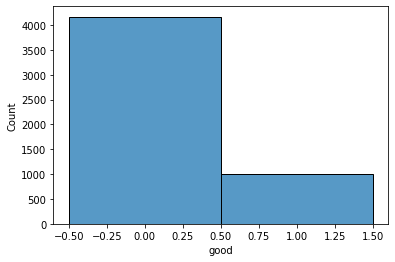

In [35]:
from scipy import stats

df = df[(np.abs(stats.zscore(df)) < 4).all(axis=1)]
sns.histplot(df.good, discrete= True)

Data is imbalanced but that's not a big problem for binary classification, all we need to do is to focus mostly on precision and recall.


Now we can make train-test split and normalize the data.

In [36]:
from sklearn.model_selection import train_test_split

X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

min = X_train.min()
max = X_train.max()
for name in df.columns[:-1]:
  X_train[name] = (X_train[name] - min[name]) / (max[name] - min[name])
  X_test[name] = (X_test[name] - min[name]) / (max[name] -min[name])

##Model selection

Printing all the metrics in single line of code was convenient, so we will make a function for this task, just as we did for regression, but this time  without oversampling.

In [37]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

def val_scores2(model, X=X_train, y=y_train, folds=5):

  accuracy = cross_val_score(model, X, y, cv=cv, scoring = 'accuracy')
  precision = cross_val_score(model, X, y, cv=cv, scoring = 'precision')
  recall = cross_val_score(model, X, y, cv=cv, scoring = 'recall')
  roc_auc = cross_val_score(model, X, y, cv=cv, scoring = 'roc_auc')


  return {'accuracy':np.mean(accuracy), 'precision':np.mean(precision), 'recall':np.mean(recall), 'roc_auc':np.mean(roc_auc)}

Once again we will start by brief examination of many models to chose our candidates for futher exploration.

In [38]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model.ridge import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Perceptron


models = [LogisticRegression(random_state=42),
          KNeighborsClassifier(),
          RidgeClassifier(),
          SVC(random_state=42),
          # GaussianProcessClassifier(random_state=42),
          DecisionTreeClassifier(random_state=42),
          RandomForestClassifier(random_state=42),
          # MLPClassifier(random_state=42),
          AdaBoostClassifier(random_state=42),
          GaussianNB(),
          LinearDiscriminantAnalysis(),
          QuadraticDiscriminantAnalysis(),
          GradientBoostingClassifier(),
          Perceptron()]

In [39]:
for model in models: 
  print(type(model).__name__)
  print(val_scores2(model))

LogisticRegression
{'accuracy': 0.8240082410268874, 'precision': 0.5993531254547166, 'recall': 0.2719856377948124, 'roc_auc': 0.8311007496074423}
KNeighborsClassifier
{'accuracy': 0.8276625345787471, 'precision': 0.5702600422876117, 'recall': 0.4458255707003545, 'roc_auc': 0.7881123017330154}
RidgeClassifier
{'accuracy': 0.8280956514693797, 'precision': 0.7014562550166266, 'recall': 0.20074248443237103, 'roc_auc': 0.8289540906284385}
SVC
{'accuracy': 0.8364843686702084, 'precision': 0.702543680200202, 'recall': 0.26989453696644394, 'roc_auc': 0.8250175161555365}
DecisionTreeClassifier
{'accuracy': 0.7728034538236283, 'precision': 0.4195295852916085, 'recall': 0.45110655702646, 'roc_auc': 0.650544153622533}
RandomForestClassifier
{'accuracy': 0.8386362952417329, 'precision': 0.6510171744417083, 'recall': 0.3548762977663973, 'roc_auc': 0.8508127080871942}
AdaBoostClassifier
{'accuracy': 0.8222889683669573, 'precision': 0.5622886261746942, 'recall': 0.3749287803138904, 'roc_auc': 0.826105

Choosing the right model might be hard as each has it's strengths and weaknesses, we see huge tradoffs between precision and recall. For now, the most promising algorithm is QuadraticDiscriminantAnalysis which seems immune to this problem and maintains high precision while scoring really high in recall.   Let's try combining the models. We will try combinations of 2 and 3 models, because there will ba a lot of combinations, we will initially filter them. Also we will skip the worst models and these that do not provide probability predictions, as we want to use soft voting. 

For our filter:

1.   recall is important as we want to skip as few good wines as possible, because these could be tested manually later, let's say we want a recall above 0.55
2.   precision is not that important, however we can't abandon this metric. Precision above 0.45 should be enough.

For now our best bet is QuadraticDiscriminantAnalysis with 0.664 recall and 0.475 precision

In [40]:
from sklearn.ensemble import VotingClassifier
import itertools

LR = LogisticRegression(random_state=42)
LDA = LinearDiscriminantAnalysis()
ABC = AdaBoostClassifier(random_state=42)
RFC = RandomForestClassifier(random_state=42)
MLPC = MLPClassifier(random_state=42)
GNB = GaussianNB()
QDA = QuadraticDiscriminantAnalysis()
KNC = KNeighborsClassifier()

models=[LR, LDA, ABC, RFC, MLPC, GNB, QDA, KNC]

for i,j in itertools.combinations(models, 2):
  vote = VotingClassifier([(type(i).__name__,i),
                           (type(j).__name__, j)],
                           voting='soft'
                           )
  scores = val_scores2(vote)
  if (scores['precision']>0.45 and scores['recall']>0.55):
    print(type(i).__name__ , '+', type(j).__name__)
    print(scores)

print('\n')

for i,j,k in itertools.combinations(models, 3):
  vote = VotingClassifier([(type(i).__name__,i),
                           (type(j).__name__,j),
                           (type(k).__name__, k)],
                           voting='soft'
                           )
  scores = val_scores2(vote)
  if (scores['precision']>0.45 and scores['recall']>0.55):
    print(type(i).__name__ , '+', type(j).__name__, '+', type(k).__name__)
    print(scores)


LogisticRegression + GaussianNB
{'accuracy': 0.8012039769899417, 'precision': 0.48699406313662247, 'recall': 0.5524397701434497, 'roc_auc': 0.8127466097651087}
LinearDiscriminantAnalysis + GaussianNB
{'accuracy': 0.800341910020024, 'precision': 0.4851920274347141, 'recall': 0.5602892208540983, 'roc_auc': 0.8144316239526}
AdaBoostClassifier + QuadraticDiscriminantAnalysis
{'accuracy': 0.795396367929442, 'precision': 0.4790831278718283, 'recall': 0.6614995116931015, 'roc_auc': 0.8292797799218306}
RandomForestClassifier + GaussianNB
{'accuracy': 0.8074405361297267, 'precision': 0.5011377624606326, 'recall': 0.6020615832574941, 'roc_auc': 0.8306063052424539}
RandomForestClassifier + QuadraticDiscriminantAnalysis
{'accuracy': 0.8293873629871408, 'precision': 0.5572674588483413, 'recall': 0.5655450662778103, 'roc_auc': 0.8515681122480796}
MLPClassifier + GaussianNB
{'accuracy': 0.8035697998773106, 'precision': 0.49292161367521875, 'recall': 0.5750117084361575, 'roc_auc': 0.8253306382859096}


We achived some good all-rounders like RFC+QDA, QDA+KNC or ABC+RFC+QDA all of which scored about 0.56 in both recall and precision while mainataining high accuracy.

 If we are focusing on recall, combination of ABC+QDA looks almost identical to base QDA. However it has one advantage, we can try to tune it as ABC has some tunable parameters in contrast to QDA.



## Hyperparameter optimization

 
Let's try to optimize QDA+KNC and ABC+QDA via validation curve. Firstly we will create a function that plots validation curves for chosen metrics, and parameters.

In [41]:
from sklearn.model_selection import validation_curve

def plot_validation_curve(model, param_name, param_range, scorings, X=X_train, y=y_train, cv=cv, figsize=(12,8)):
  plt.figure(figsize=figsize)
  for scoring in scorings:
    train_scores, test_scores = validation_curve(model, X, y,
                                                 param_name=param_name,
                                                 param_range=param_range,
                                                 cv=cv,
                                                 scoring=scoring)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    c = np.random.rand(3,)/1.2
    plt.plot(param_range, train_mean,'o-', color=c,  label="training "+scoring)
    plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.3, color=c)
    plt.plot(param_range, test_mean,'o--', color=c,  label="validation "+scoring)
    plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.3, color=c)
  plt.xlabel(param_name)
  plt.grid()
  plt.legend()

For QDA+KNC we will optimize the n_neighbors parameter.

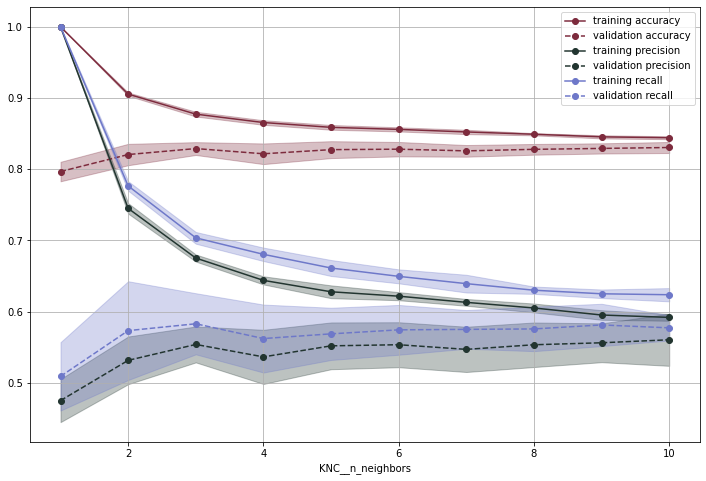

In [42]:
QDA_KNC = VotingClassifier([ ('QDA', QDA),('KNC', KNC)],
                              voting='soft')
plot_validation_curve(QDA_KNC, "KNC__n_neighbors", list(range(1,11)), ['accuracy', 'precision', 'recall'])

3 neighbors is enough for our algorithm to reach it's full potential. Let's save this model, and take a look on improvement.

In [43]:
KNC1 = KNeighborsClassifier(n_neighbors=3)
best_QDA_KNC = VotingClassifier([ ('QDA', QDA),('KNC', KNC1)],
                              voting='soft')
print('base QDA_KNC:')
print(val_scores2(QDA_KNC))
print('optimized QDA_KNC:')
print(val_scores2(best_QDA_KNC))

base QDA_KNC:
{'accuracy': 0.8274477123048254, 'precision': 0.551902456252178, 'recall': 0.5687404010474395, 'roc_auc': 0.8403641556418068}
optimized QDA_KNC:
{'accuracy': 0.8289551720545851, 'precision': 0.5538573132194553, 'recall': 0.5828852535426756, 'roc_auc': 0.8409110152831841}


In ABC+QDA we will do the same procedure for parameter n_estimators.

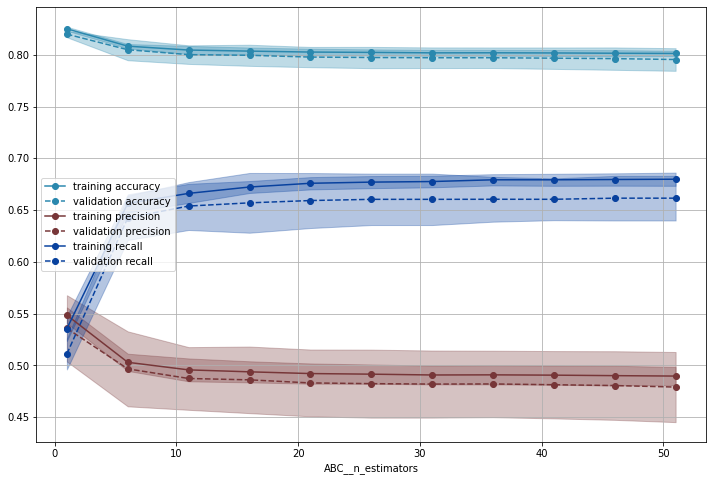

In [44]:
ABC_QDA = VotingClassifier([ ('ABC', ABC),('QDA', QDA)],
                              voting='soft')
plot_validation_curve(ABC_QDA, "ABC__n_estimators", list(range(1, 52, 5)),  ['accuracy', 'precision', 'recall'])

As we see the results have already converged within the default 50 iterations.

Lastly let's try to optimize ABC+RFC+QDA. There are a lot of parameters to tune in RFC so we will use grid search.

In [45]:
from sklearn.model_selection import GridSearchCV
RFC = RandomForestClassifier( )
ABC_RFC_QDA = VotingClassifier([ ('RFC', RFC), ('QDA', QDA),('ABC', ABC)],
                              voting='soft')
# RFC__n_estimators = [50, 100, 150, 200, 250, 300]
# RFC__max_features = ['auto', 'sqrt', 'log2']
# RFC__criterion = ['gini', 'entropy']
# RFC__max_depth = [1, 2, 3, 5, 8, 12, 15, 20, 30]
# RFC__max_depth.append(None)
# RFC__min_samples_split = [1, 2, 3, 4, 5, 8, 10]
# RFC__bootstrap = [True, False]

# param_grid = {'RFC__n_estimators' :RFC__n_estimators,
#               'RFC__max_features': RFC__max_features,
#               'RFC__criterion': RFC__criterion,
#               'RFC__max_depth': RFC__max_depth,
#               'RFC__min_samples_split': RFC__min_samples_split,
#               'RFC__bootstrap': RFC__bootstrap, 
#               'RFC__random_state: 42'}

# random_search = RandomizedSearchCV(ABC_RFC_QDA, n_iter=500, param_distributions=param_grid, verbose=1, cv=cv)
# random_search.fit(X_train, y_train)
# print(random_search.best_params_)
# best_ABC_RFC_QDA = random_search.best_estimator_



# results
RFC1 = RandomForestClassifier(bootstrap=False,
                              criterion= 'entropy',
                              max_depth= 30,
                              max_features='auto',
                              min_samples_split=4,
                              n_estimators=150,
                              random_state=42)
best_ABC_RFC_QDA = VotingClassifier([('ABC', ABC), ('RFC', RFC1), ('QDA', QDA)],
                                    voting='soft')

Are there any significant improvements?

In [46]:
print('base ABC_RFC_QDA:')
print(val_scores2(ABC_RFC_QDA))
print('optimized ABC_RGC_QDA:')
print(val_scores2(best_ABC_RFC_QDA))

base ABC_RFC_QDA:
{'accuracy': 0.8291713832656227, 'precision': 0.5570932053622529, 'recall': 0.5600603519679404, 'roc_auc': 0.8520582235772848}
optimized ABC_RGC_QDA:
{'accuracy': 0.8302480410199429, 'precision': 0.5597398928357069, 'recall': 0.5685613724877949, 'roc_auc': 0.854552126376589}


There is a small improvement.

##Results

At the end we have three estimators. Based on scores we expect ABC+RFC+QDA and QDA+KNC to perform simmilarly with balanced precision and recall. ABC+QDA has a better recall but at cost of precision. We will plot confusion matrices for all three on testing set.

[Text(849.9882352941178, 0.5, 'True'), Text(0.5, 33.0, 'Predicted')]

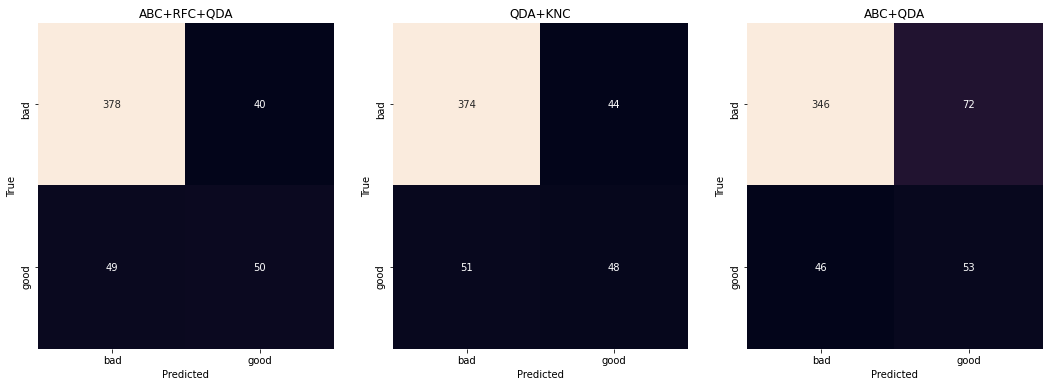

In [47]:
best_ABC_RFC_QDA.fit(X_train, y_train)
y_pred1 = best_ABC_RFC_QDA.predict(X_test)
con1 = metrics.confusion_matrix(y_test, y_pred1)

best_QDA_KNC.fit(X_train, y_train)
y_pred2 = best_QDA_KNC.predict(X_test)
con2 = metrics.confusion_matrix(y_test, y_pred2 )

ABC_QDA.fit(X_train, y_train)
y_pred3 = ABC_QDA.predict(X_test)
con3 = metrics.confusion_matrix(y_test, y_pred3 )


f,(ax1,ax2, ax3) = plt.subplots(1,3, figsize=(18,6))

sns.heatmap(con1, annot=True, fmt='d', cbar=False, xticklabels=['bad', 'good'], yticklabels=['bad', 'good'], ax=ax1)
ax1.set_title('ABC+RFC+QDA')
ax1.set(xlabel='Predicted', ylabel='True')

sns.heatmap(con2, annot=True, fmt='d', cbar=False, xticklabels=['bad', 'good'], yticklabels=['bad', 'good'], ax=ax2)
ax2.set_title('QDA+KNC')
ax2.set(xlabel='Predicted', ylabel='True')

sns.heatmap(con3, annot=True, fmt='d', cbar=False, xticklabels=['bad', 'good'], yticklabels=['bad', 'good'], ax=ax3)
ax3.set_title('ABC+QDA')
ax3.set(xlabel='Predicted', ylabel='True')


#Other attempts of binary clasification- xgboost and neural networks

As our results are not satysfying, our last try will be to use advanced models i.e. xgboost and neural networks.

In [48]:
#Deleting previously downloaded models, if there are any, to prevent problems with overwriting if the future 

!rm -rf /content/content
!rm /content/NN.zip
!rm /content/bst

rm: cannot remove '/content/NN.zip': No such file or directory
rm: cannot remove '/content/bst': No such file or directory


 ## xgboost

Let's train our xgboost estimator. We will use low eta and high number of rounds for the best results.

In [49]:
import xgboost as xgb

param = {
    'max_depth':3,
    'eta': 0.01,
    'objective': 'binary:logistic',
    'nthread': -1,
    'eval_metric': 'aucpr'
}
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
# bst = xgb.train(param,  dtrain, num_boost_round=10000, evals=[(dtest, 'eval'), (dtrain, 'train')])
# bst.save_model('bst')

#downloading the model
!gdown --id '1t54sAIha5xOFCZbaUPwC9dMcNxHXl2J2'
bst = xgb.Booster()  
bst.load_model('/content/bst') 

Downloading...
From: https://drive.google.com/uc?id=1t54sAIha5xOFCZbaUPwC9dMcNxHXl2J2
To: /content/bst
6.31MB [00:00, 38.4MB/s]


To plot confussion marix we need to remember that XGBoost returns probability of being class 1 and we need to convert it to label.

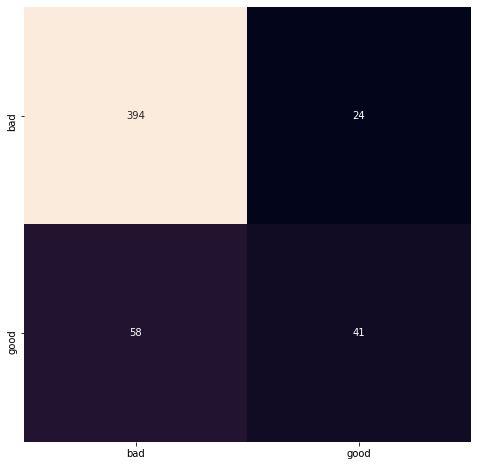

In [50]:
plt.figure(figsize=(8,8))
y_pred = np.round(bst.predict(dtest))
con = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(con, annot=True, fmt='d', cbar=False, xticklabels=['bad', 'good'], yticklabels=['bad', 'good'])

We can adjust the recall/precision tradeoff by using different thresholds for label predictions. Observations with probability above threshold will be labbeled as 1 and those below will be 0's. Lowering the theeshold will increase recall but at cost of precision. To focus more on recall we could lower the threshold from default 0.5 to, for instance, 0.4.

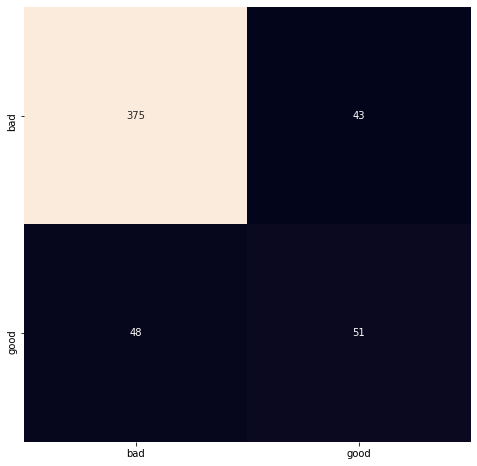

In [51]:
plt.figure(figsize=(8,8))
y_pred = np.where(bst.predict(dtest)>0.4, 1, 0)
con = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(con, annot=True, fmt='d', cbar=False, xticklabels=['bad', 'good'], yticklabels=['bad', 'good'])
 

Just from curiosity let's take a look on how our metrics would behave for specific thresholds.

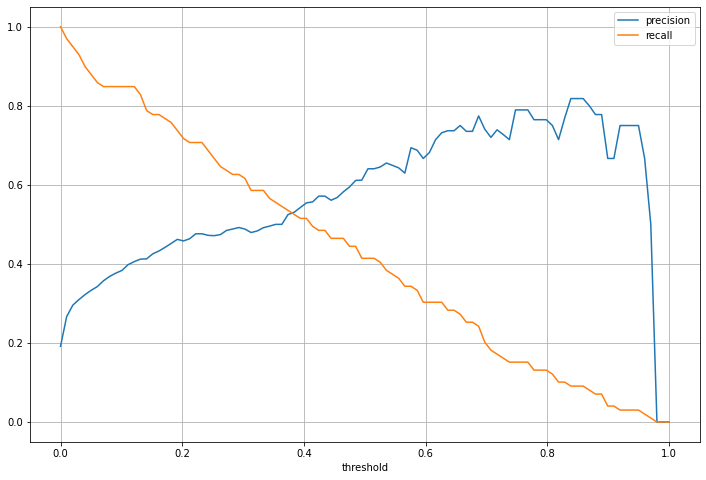

In [52]:
plt.figure(figsize=(12,8))

thresholds = np.linspace(0, 1, 100)
precisions = []
recalls = []
prob = bst.predict(dtest)
for threshold in thresholds:
  y_pred = np.where(prob>threshold, 1, 0)
  recalls.append(metrics.recall_score(y_test, y_pred))
  precisions.append(metrics.precision_score(y_test, y_pred))
plt.plot(thresholds, precisions, label='precision')
plt.plot(thresholds, recalls, label='recall')
plt.xlabel('threshold')
plt.legend()
plt.grid()


## nueral network

Using neural networks for our task is not an overkill, we saw that simpler models are not enough.

We will make neuaral network containing 4 dense layers with some dropout to prevent overfitting.

In [53]:
import keras

NN = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(X.columns.size,)),
                       keras.layers.Dropout(0.2),
                       keras.layers.Dense(64, activation='relu'),
                       keras.layers.Dropout(0.1),
                       keras.layers.Dense(32, activation='relu'),
                       keras.layers.Dense(1,activation='sigmoid')])

Now let's train our network.

In [54]:
NN.compile(loss='binary_crossentropy',
          metrics=['accuracy'],
          optimizer=keras.optimizers.Adam(lr=0.0003))
# history = NN.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test))

# NN.save('NN')
# !zip -r /content/NN.zip /content/NN


#downloading the model
!gdown --id '1j9xD0jM7SL6QeaKkL3-db3cQwqXjOQD7'
!unzip '/content/NN.zip'
NN = keras.models.load_model('/content/content/NN')

Downloading...
From: https://drive.google.com/uc?id=1j9xD0jM7SL6QeaKkL3-db3cQwqXjOQD7
To: /content/NN.zip
100% 146k/146k [00:00<00:00, 20.7MB/s]
Archive:  /content/NN.zip
   creating: content/NN/
  inflating: content/NN/saved_model.pb  
   creating: content/NN/assets/
   creating: content/NN/variables/
  inflating: content/NN/variables/variables.index  
  inflating: content/NN/variables/variables.data-00000-of-00001  


Finally let's take a look on the results.

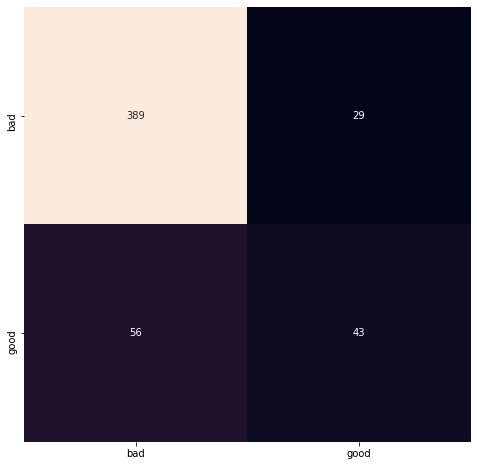

In [55]:
plt.figure(figsize=(8,8))
pred = np.round(NN.predict(X_test))
con = metrics.confusion_matrix(y_test, pred)
sns.heatmap(con, annot=True, fmt='d', cbar=False, xticklabels=['bad', 'good'], yticklabels=['bad', 'good'])
 

And what would happen if we lower the threshold to 0.4 as w did in xgboost?

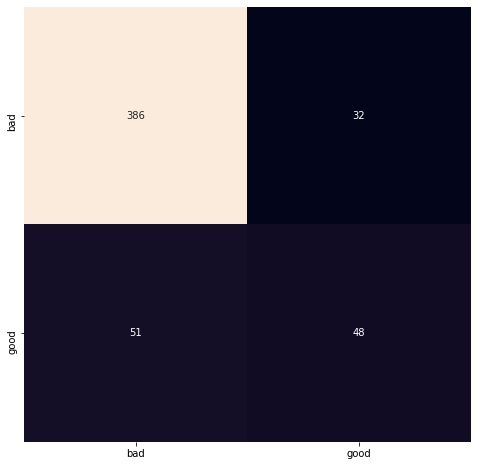

In [56]:
plt.figure(figsize=(8,8))
y_pred = np.where(NN.predict(X_test)>0.4, 1, 0)
con = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(con, annot=True, fmt='d', cbar=False, xticklabels=['bad', 'good'], yticklabels=['bad', 'good'])
 

# Final thoughts

Predicting wine quality is a difficult task for machine learning. Regression models didn't work out well and we had to chnage the character of task to obtain satysfying results. After all the attempts we can say that neural network is the best model from what we have tested. It has decent precision and recall. What's more we can easly increase the recall at cost of precision and vice versa according to our needs, by aletring the threshold.